In [8]:
library("plyr")  
library(dplyr)
library(ggplot2)
library(glue)

In [9]:
# 5 random seeds

In [10]:
output = read.table("/Users/shayecarver/condPCA/Light_Hvratin/output.txt", sep=" ", header=TRUE)

output = output %>% distinct()

# replace 19425 with 20k -- some int/ex samples only had 19k variable genes not 20k
output[output$vargenes == 19425,]$vargenes = 20000

head(output)

# rename variables so that the plot labels are better
output[output$method == "Cond_PCA",]$method = "CondPCA"
output[output$method == "scaled_NMF",]$method = "Scaled NMF"
output[output$data_param == "all_cell_types",]$data_param = "All Cell Types"
output[output$data_param == "int_ex",]$data_param = "Interneurons & Ex. Neurons"
colnames(output)[colnames(output) == "method"] <- "Method"

,method,data_param,num_cells,seed,dim,vargenes,adj.rsq,max.rsq
,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,UMAP,all_cell_types,15000,2,50,3000,0.002804858,0.002803224
2,UMAP,all_cell_types,1000,1,50,3000,0.002816732,0.002109849
3,UMAP,all_cell_types,10000,2,50,3000,0.002966791,0.003026346
4,UMAP,all_cell_types,10000,3,50,3000,0.003626456,0.003709749
5,UMAP,all_cell_types,5000,4,50,3000,0.004182305,0.003404297
6,UMAP,all_cell_types,1000,2,50,3000,0.002408852,0.001309068


In [11]:
# create a copy of the dataframe so that dplyr doesn't produce errors in groupby
tmp = output 

# compute statistic of interest across random seeds of a given simulation
compute_summary <- function(data, statistic, identifier) {
  summary_result <- data %>% group_by(Method,data_param,num_cells, dim, vargenes) %>% 
                      summarise(across(c(adj.rsq,max.rsq),statistic), .groups = 'drop') %>%
    ungroup() %>%
    as.data.frame()

    

  # Append identifier to last three columns
  last_two <- tail(colnames(summary_result), 2)
  new_col_names <- paste0(identifier, last_two)
  colnames(summary_result)[(ncol(summary_result) - 1):ncol(summary_result)] <- new_col_names
  
  return(summary_result)
}

# Compute means
means <- compute_summary(tmp, mean, "mean_")

# Compute standard errors
se <- compute_summary(tmp, ~sd(.)/sqrt(length(.)), "se_")

# Compute confidence intervals
conf <- compute_summary(tmp, ~sd(.)/sqrt(length(.))*qnorm(0.975), "conf_")

# Merge mean, se, and conf interval dataframes
merged <- means %>%
  inner_join(se, by = colnames(means)[1:5]) %>%
  inner_join(conf, by = colnames(means)[1:5])

# drop columns of dataframe with "50" and "100" in num_cells column
merged <- subset(merged, !(num_cells %in% c("50", "100")))

# add label
merged$name = as.factor(paste(merged$Method, merged$vargenes) )


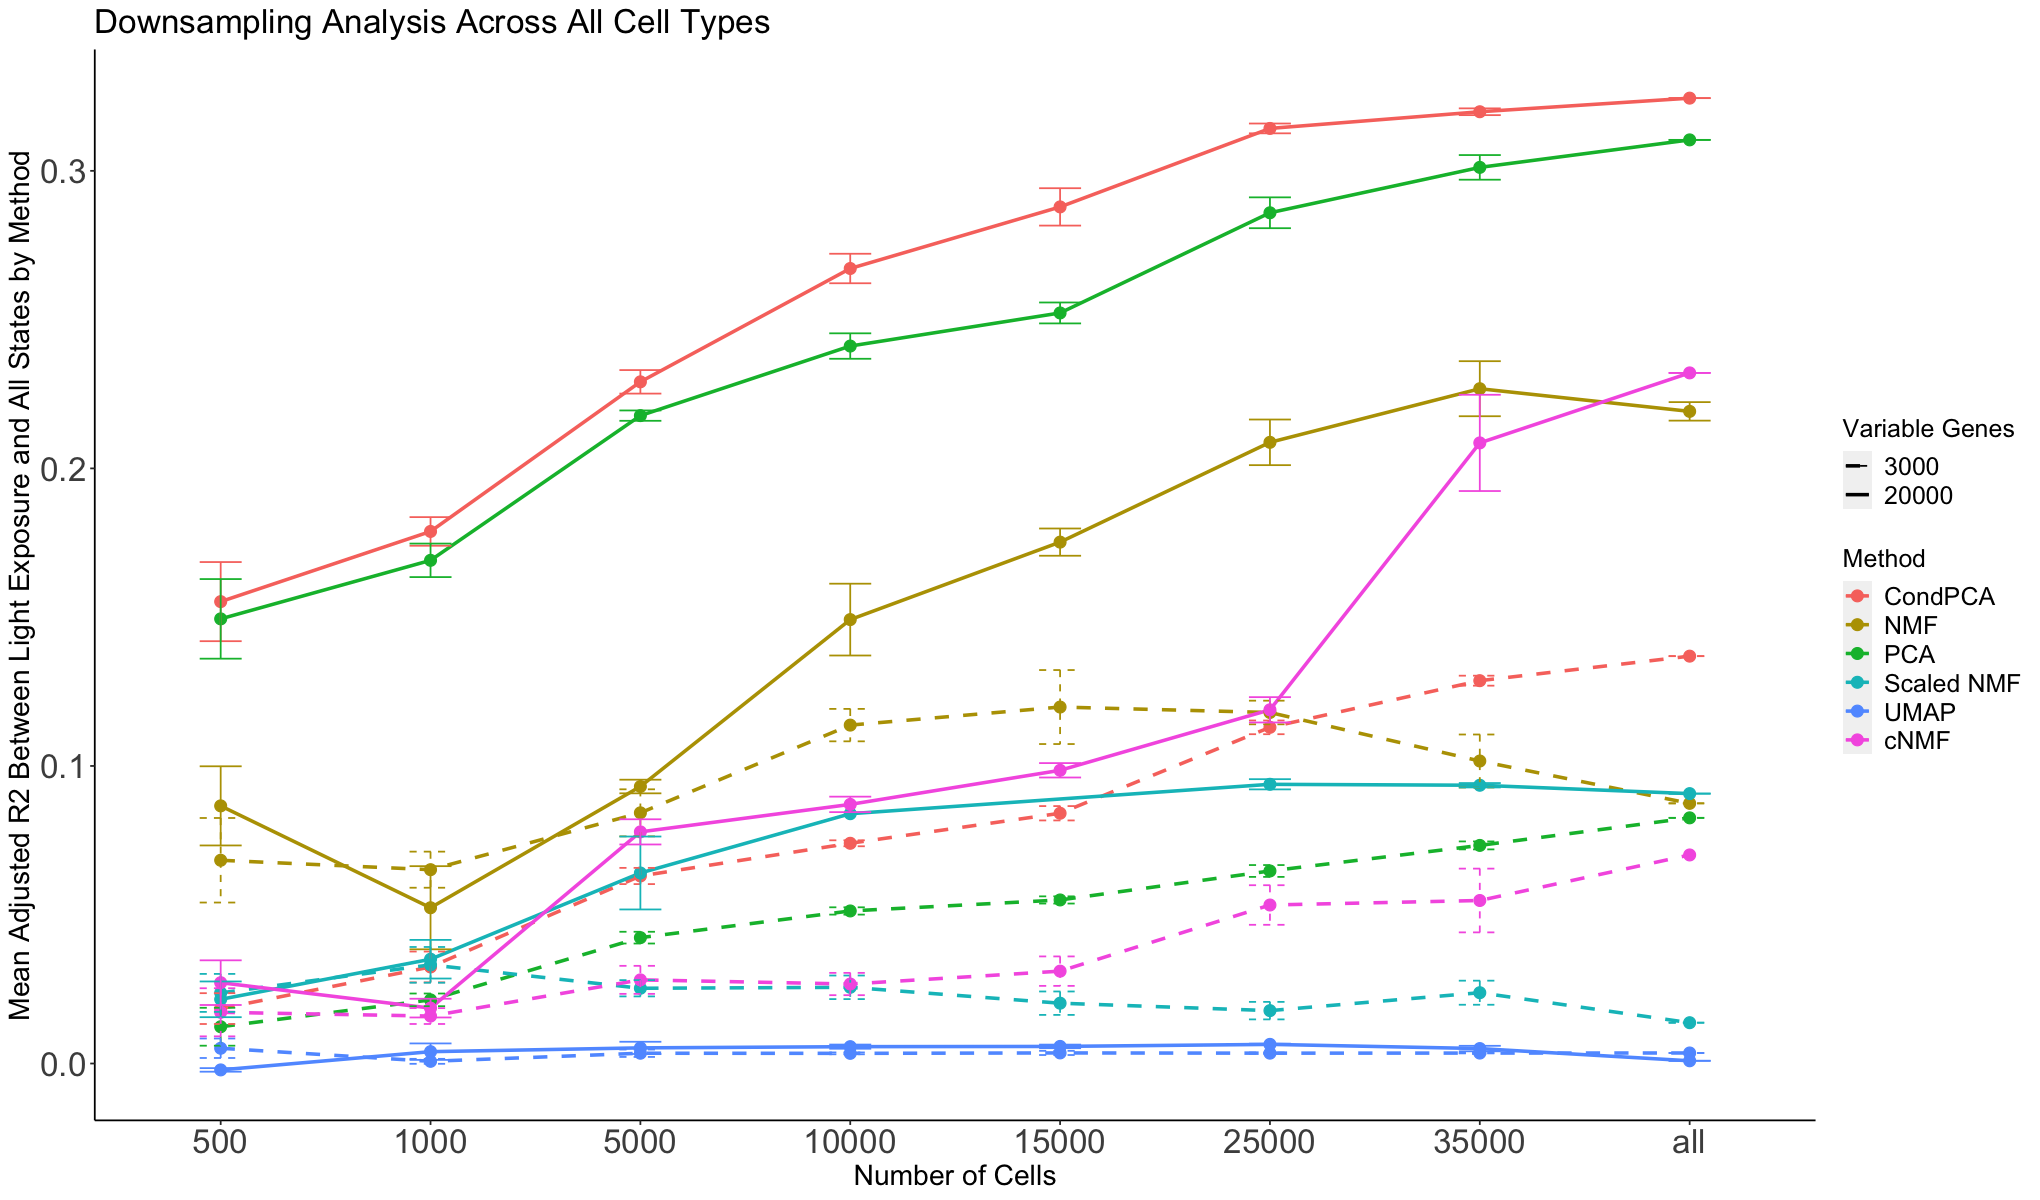

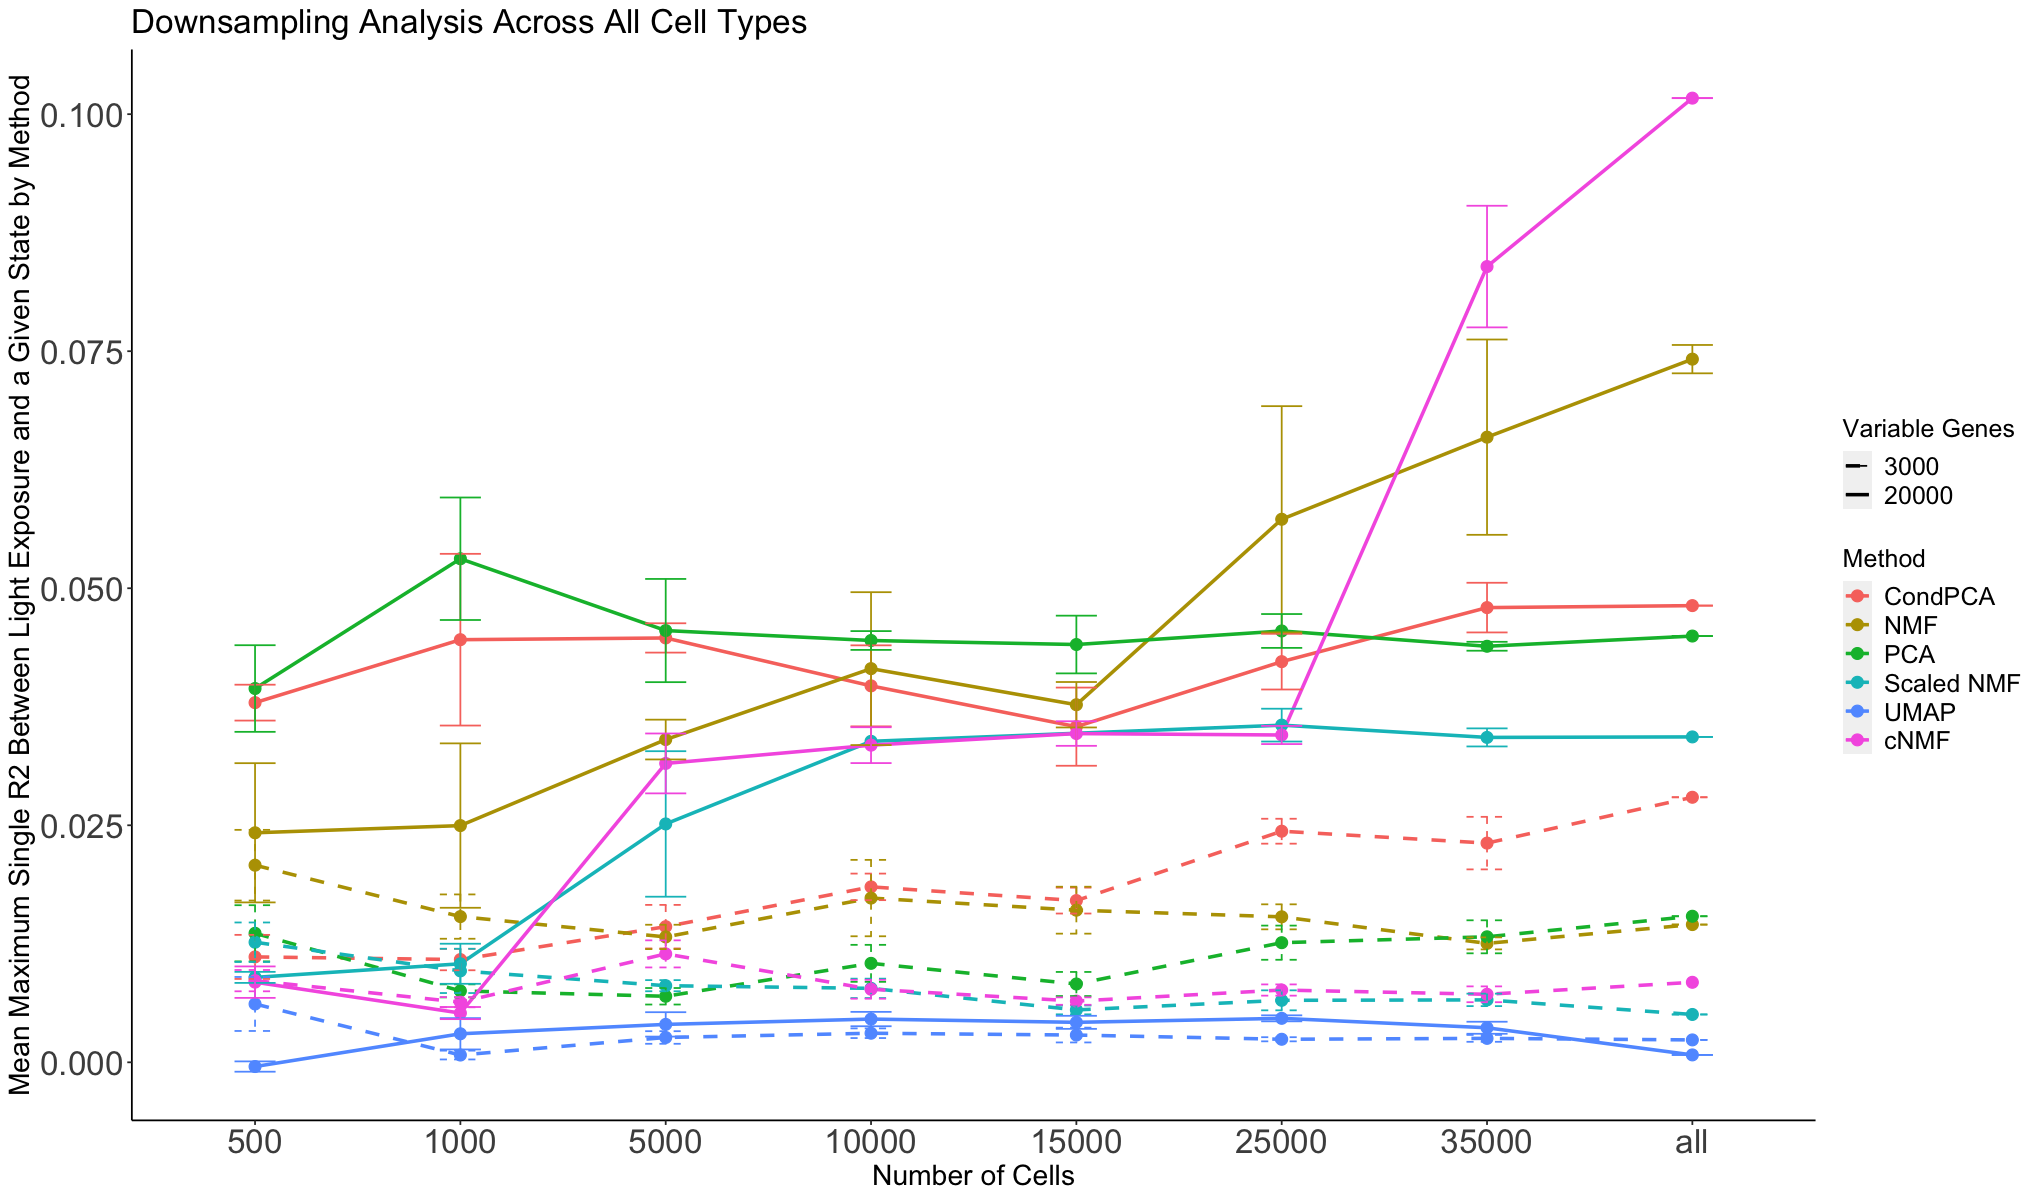

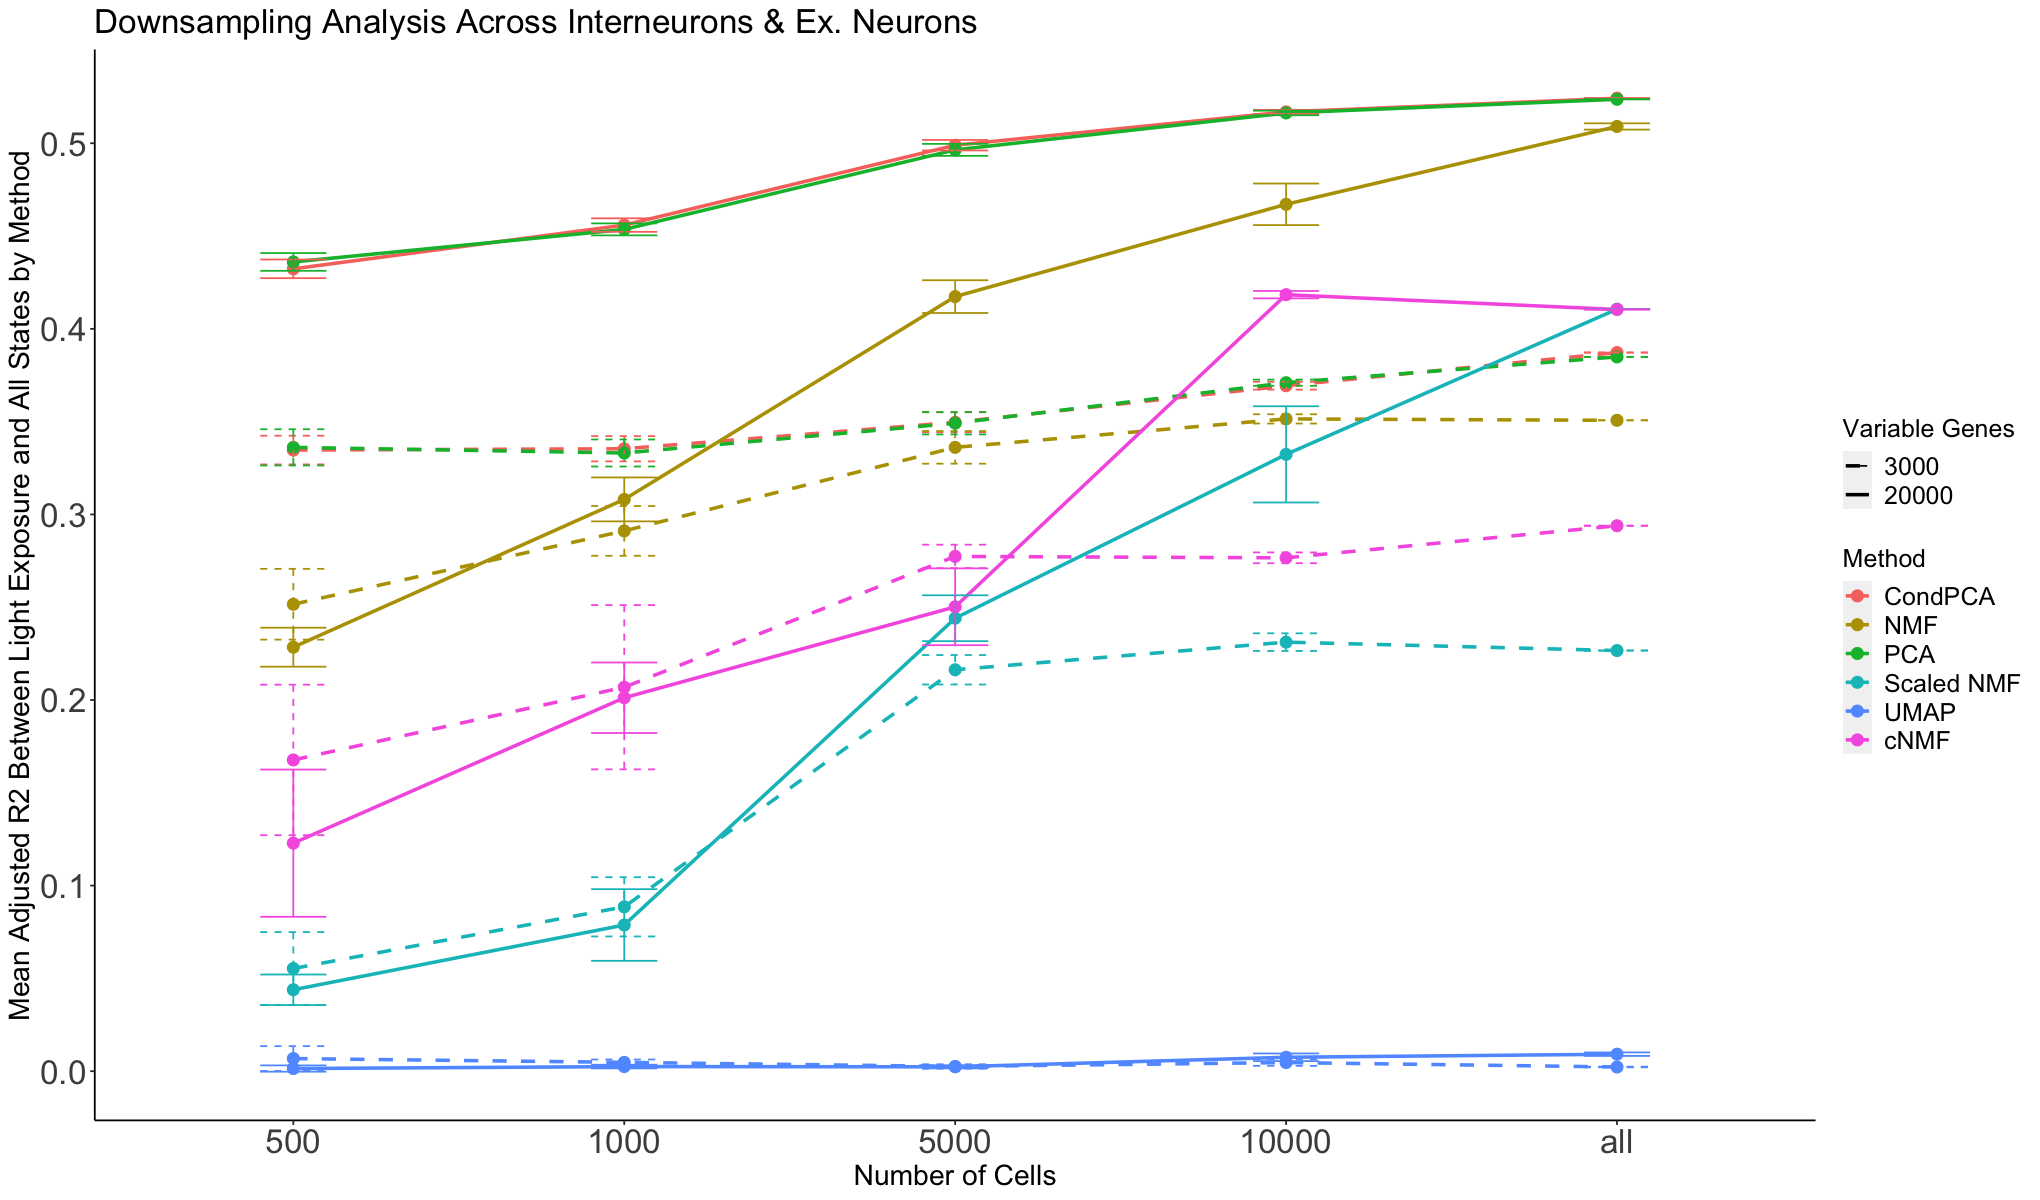

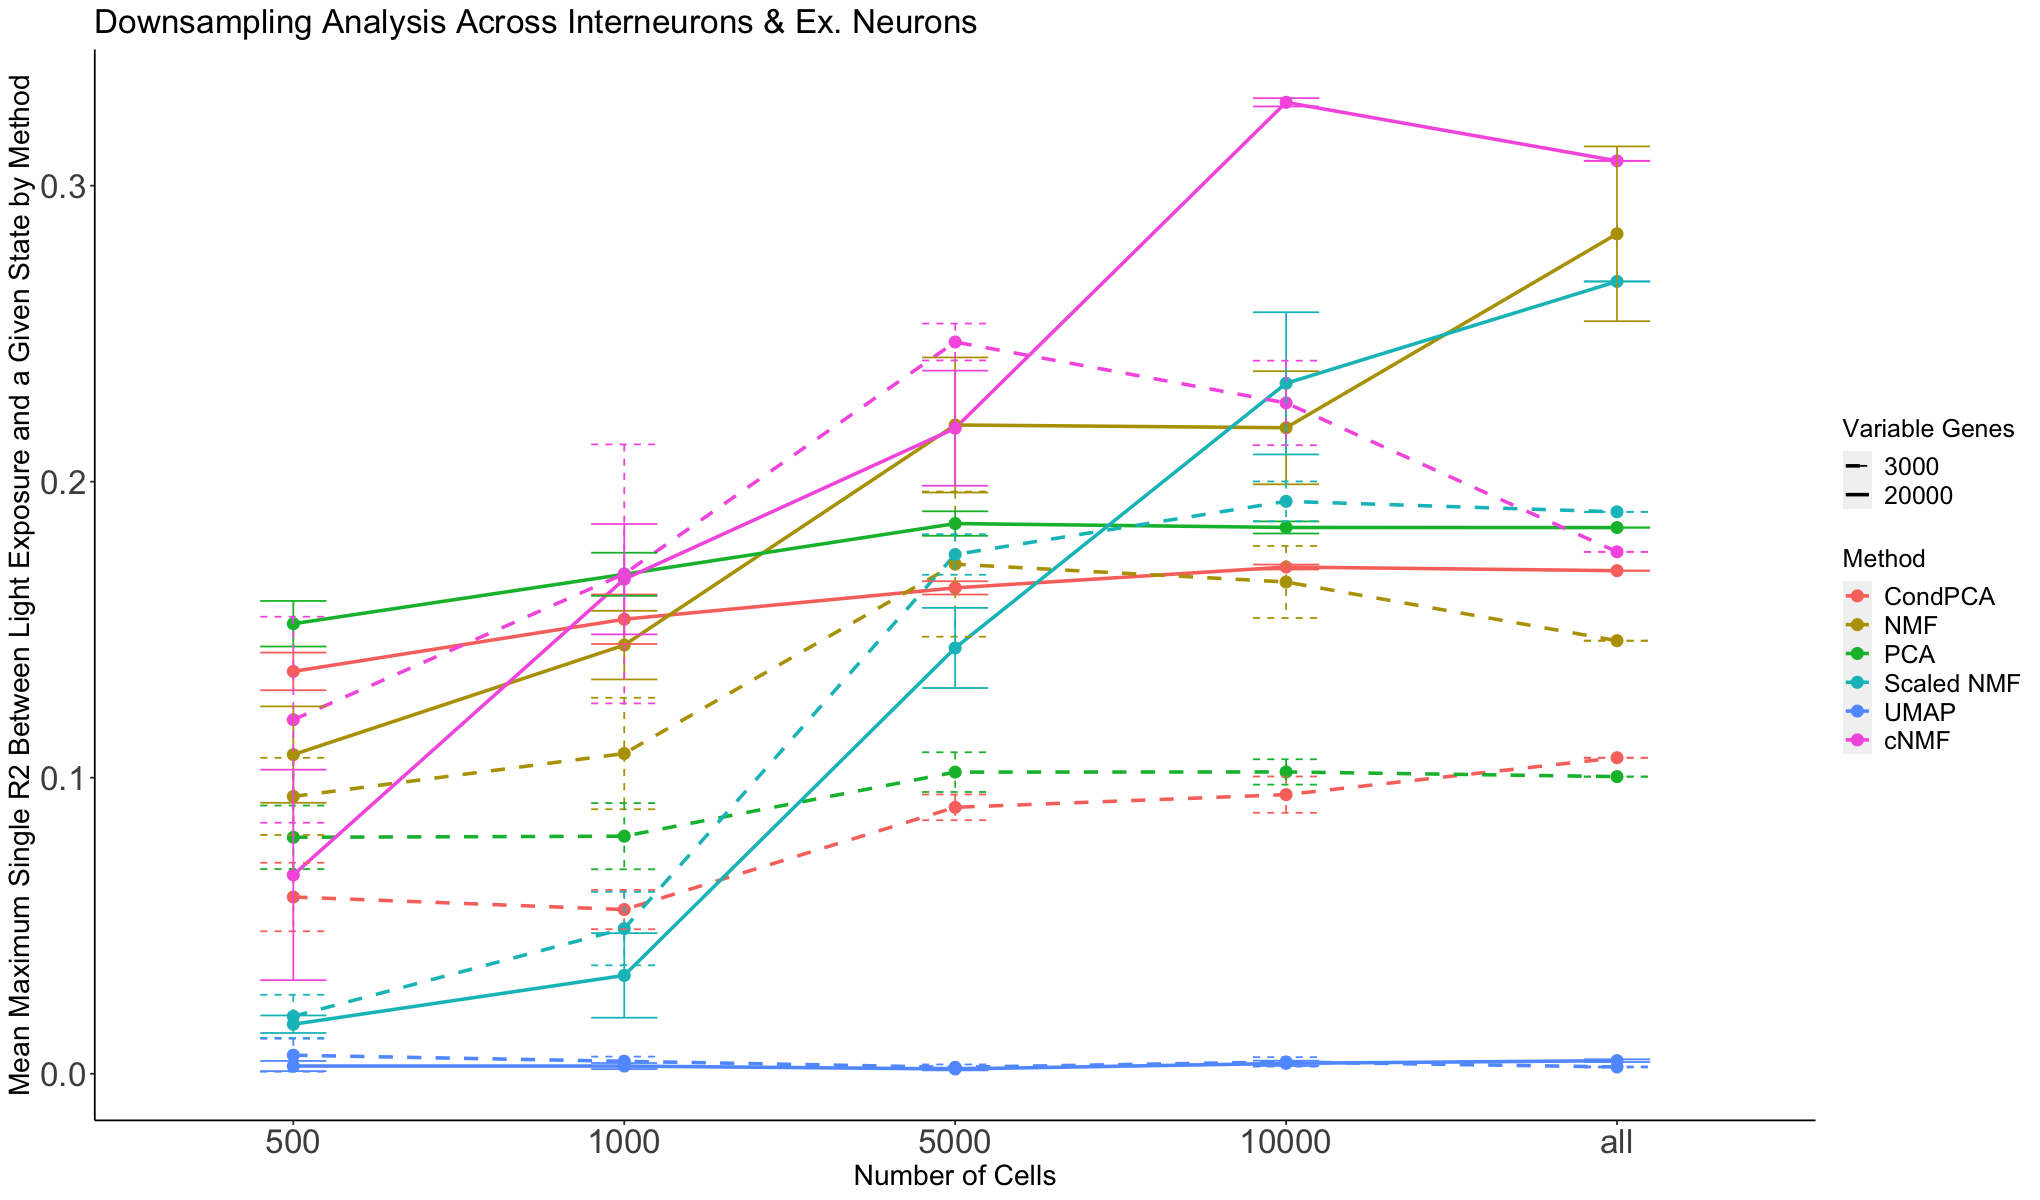

In [7]:
merged$num_cells = factor(merged$num_cells, levels = c("500","1000","5000","10000","15000","15223","20000","25000","30000","35000","40000","all"))
options(repr.plot.width = 17, repr.plot.height = 10)

stats = c("adj.rsq","max.rsq")


for (subset in unique(merged$data_param)){
    # subset dataframe to parameter of interest
    out = merged[merged$data_param == subset,]

    # Create a variable indicating which samples with 3000 vargenes should be dashed lines and 20k vargenes should be solid lines
    out$dashed_lines = ifelse(out$vargenes == "3000", "Dashed", "Solid")
    
    for (stat in stats){

        if (stat == "adj.rsq") {
            ylabel <- "Mean Adjusted R2 Between Light Exposure and All States by Method"
        } else if (stat == "max.rsq") {
            ylabel <- "Mean Maximum Single R2 Between Light Exposure and a Given State by Method"
        } else {
            stop("Unexpected value for 'stat'")
        }

        p = ggplot(out, aes(x = num_cells, y = UQ(as.name(paste0("mean_", stat))), group = name, colour = Method, linetype = dashed_lines)) +
            geom_line(linewidth = 1) +
            geom_point(size = 3) +
            geom_errorbar(aes(ymin = UQ(as.name(paste0("mean_", stat))) - UQ(as.name(paste0("se_", stat))), ymax = UQ(as.name(paste0("mean_", stat))) + UQ(as.name(paste0("se_", stat)))), width = 0.2) +
            scale_linetype_manual(name = "Variable Genes", values = c("dashed", "solid"), labels = c("3000", "20000")) +
            ggtitle(glue('Downsampling Analysis Across {subset}')) +
            labs(y = ylabel, x = "Number of Cells") +
            theme(
                axis.text.x = element_text(size = 20),
                axis.text.y = element_text(size = 20),
                text = element_text(size = 15),
                axis.text = element_text(size = 12),
                axis.title = element_text(size = 17),
                plot.title = element_text(size = 20),
                legend.text = element_text(size = 15),
                panel.grid.major = element_blank(),
                panel.grid.minor = element_blank(),
                panel.background = element_blank(),
                axis.line = element_line(colour = "black")
            )
        
        print(p)
        
        
        
        
        
        # p = ggplot(out, aes(x = num_cells, y = UQ(as.name(paste0("mean_", stat))), group = name, colour = Method, linetype = dashed_lines)) +
        #     geom_line(linewidth = 1) +
        #     geom_point(size = 3) +
        #     scale_linetype_manual(name = "Variable Genes", values = c("dashed", "solid"), labels = c("3000", "20000")) +
        #     ggtitle(glue('Downsampling Analysis Across {subset} ')) +
        #     labs(y = ylabel, x = "Number of Cells") +
        #     theme(
        #         axis.text.x = element_text(size = 20),
        #         axis.text.y = element_text(size = 20),
        #         text = element_text(size = 15),
        #         axis.text = element_text(size = 12),
        #         axis.title = element_text(size = 17),
        #         plot.title = element_text(size = 20),
        #         legend.text = element_text(size = 15),
        #         panel.grid.major = element_blank(),
        #         panel.grid.minor = element_blank(),
        #         panel.background = element_blank(),
        #         axis.line = element_line(colour = "black")
        #     )
        # print(p)
    }    
}

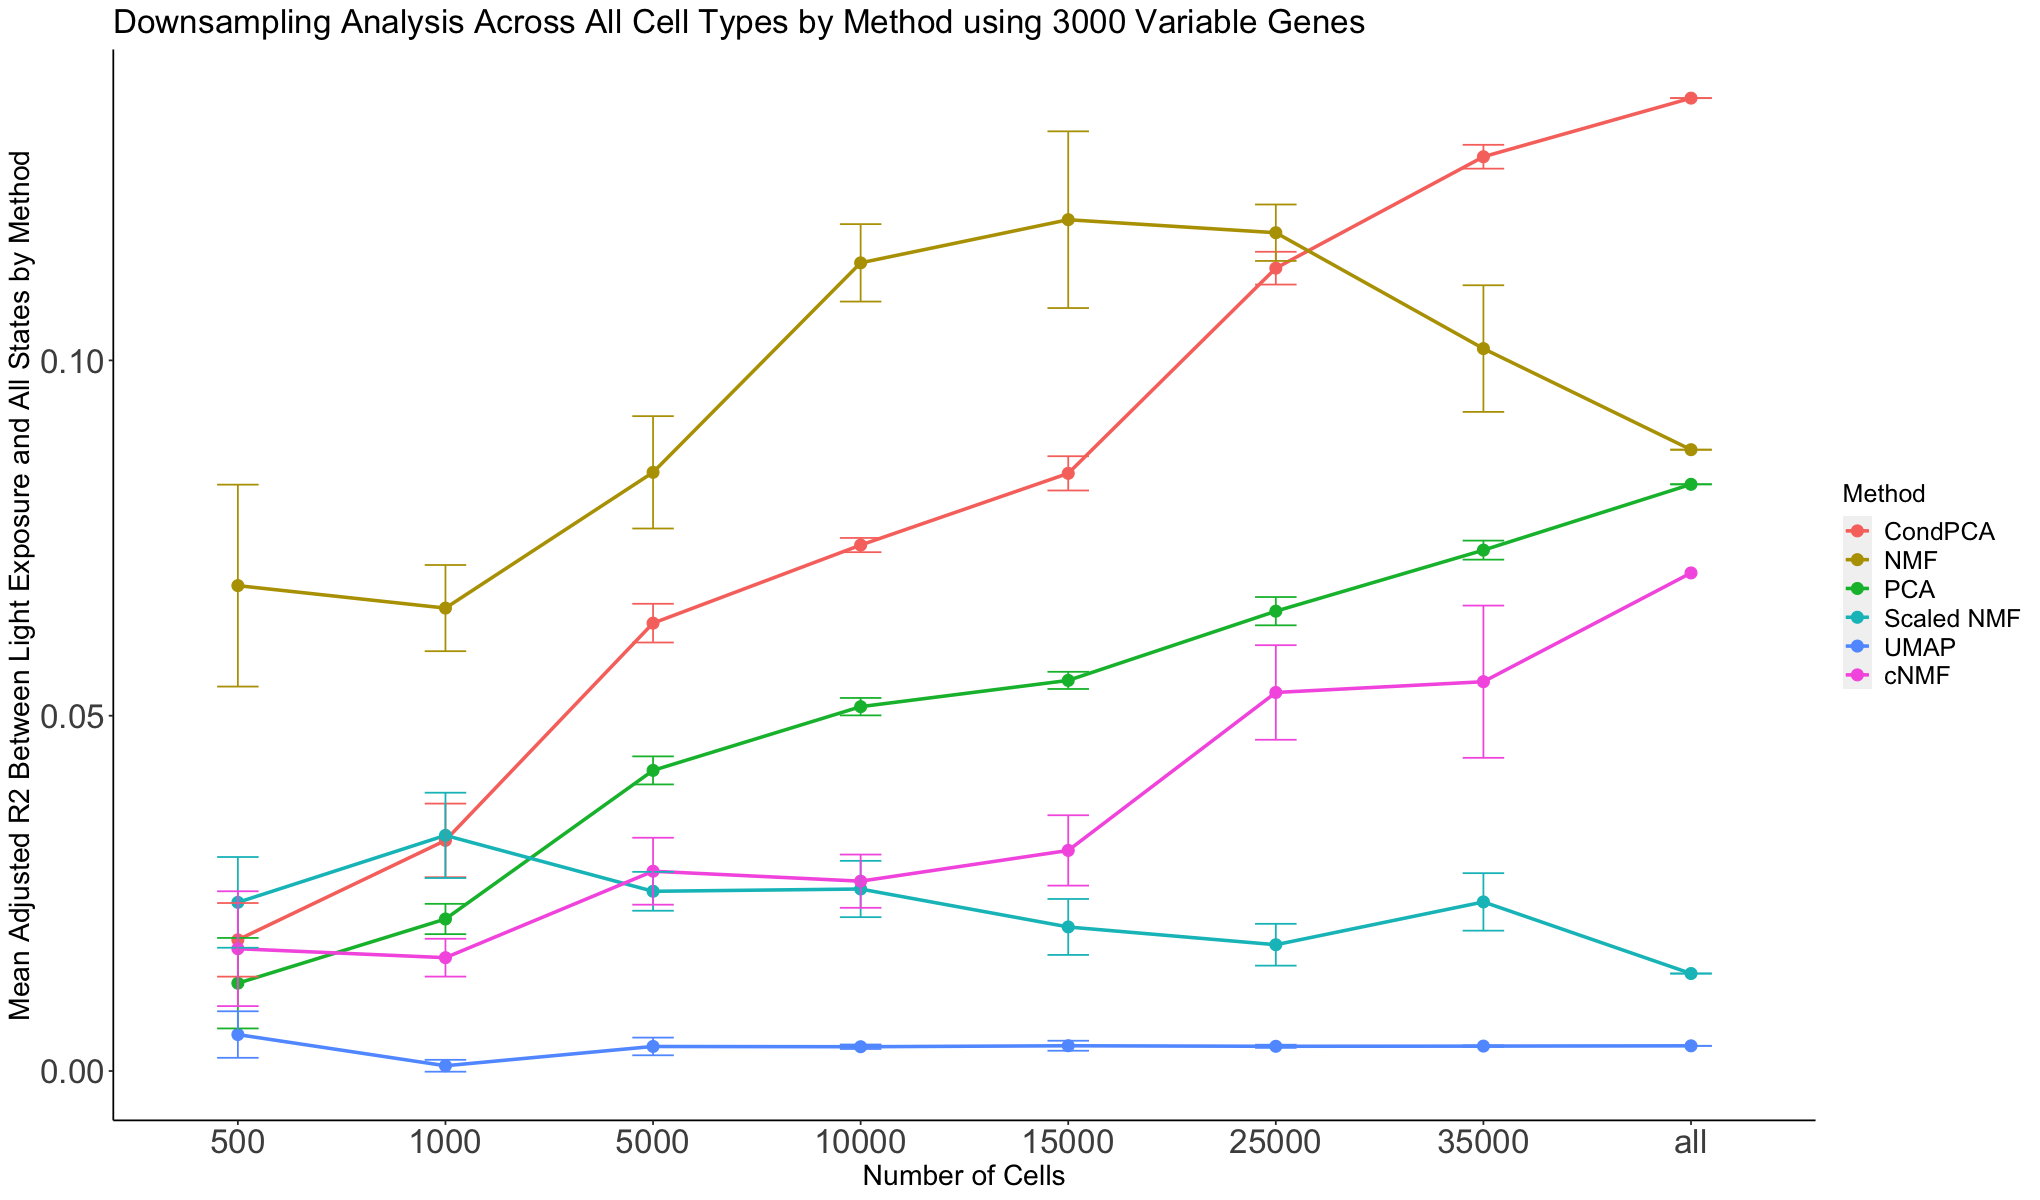

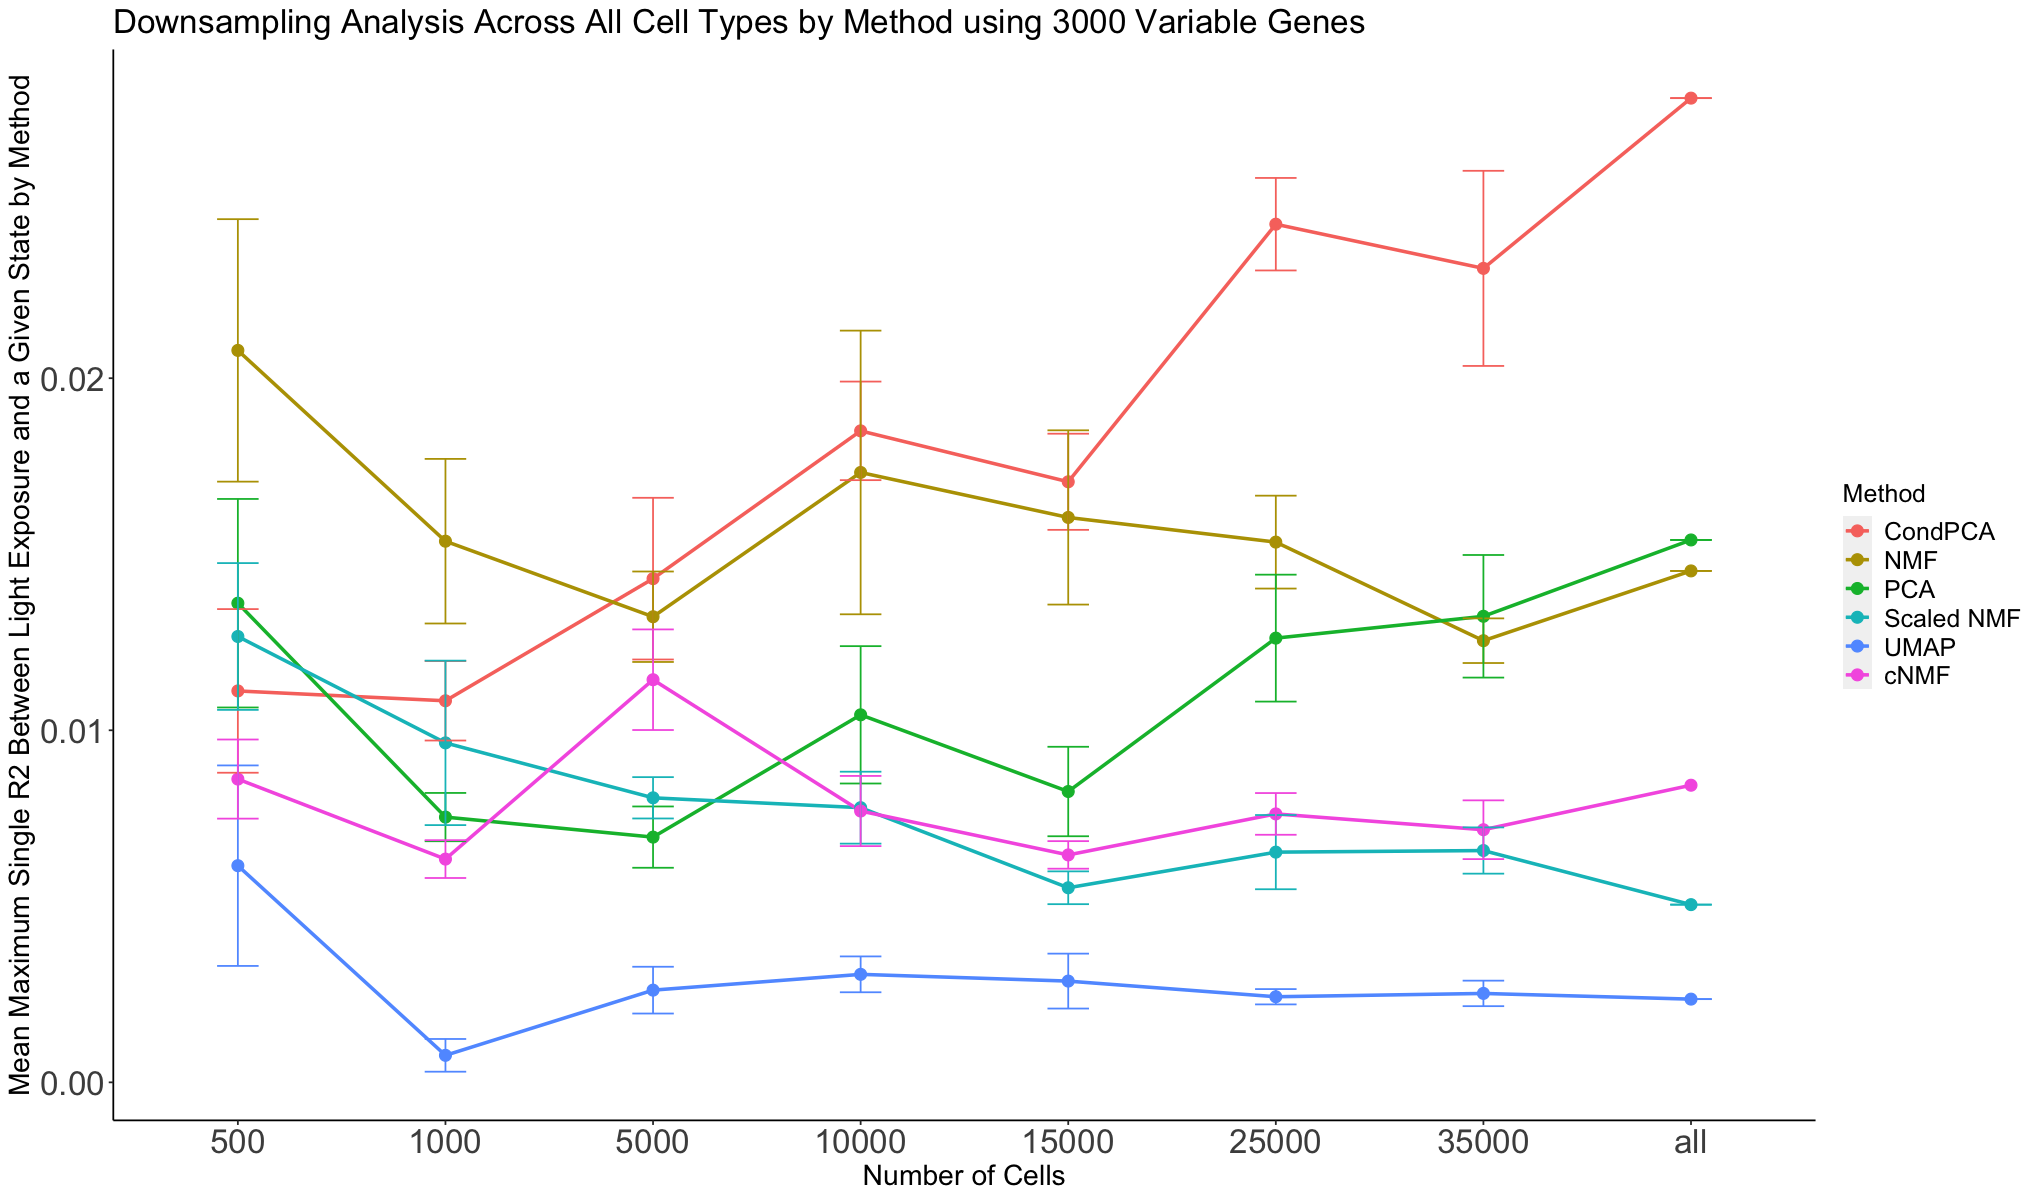

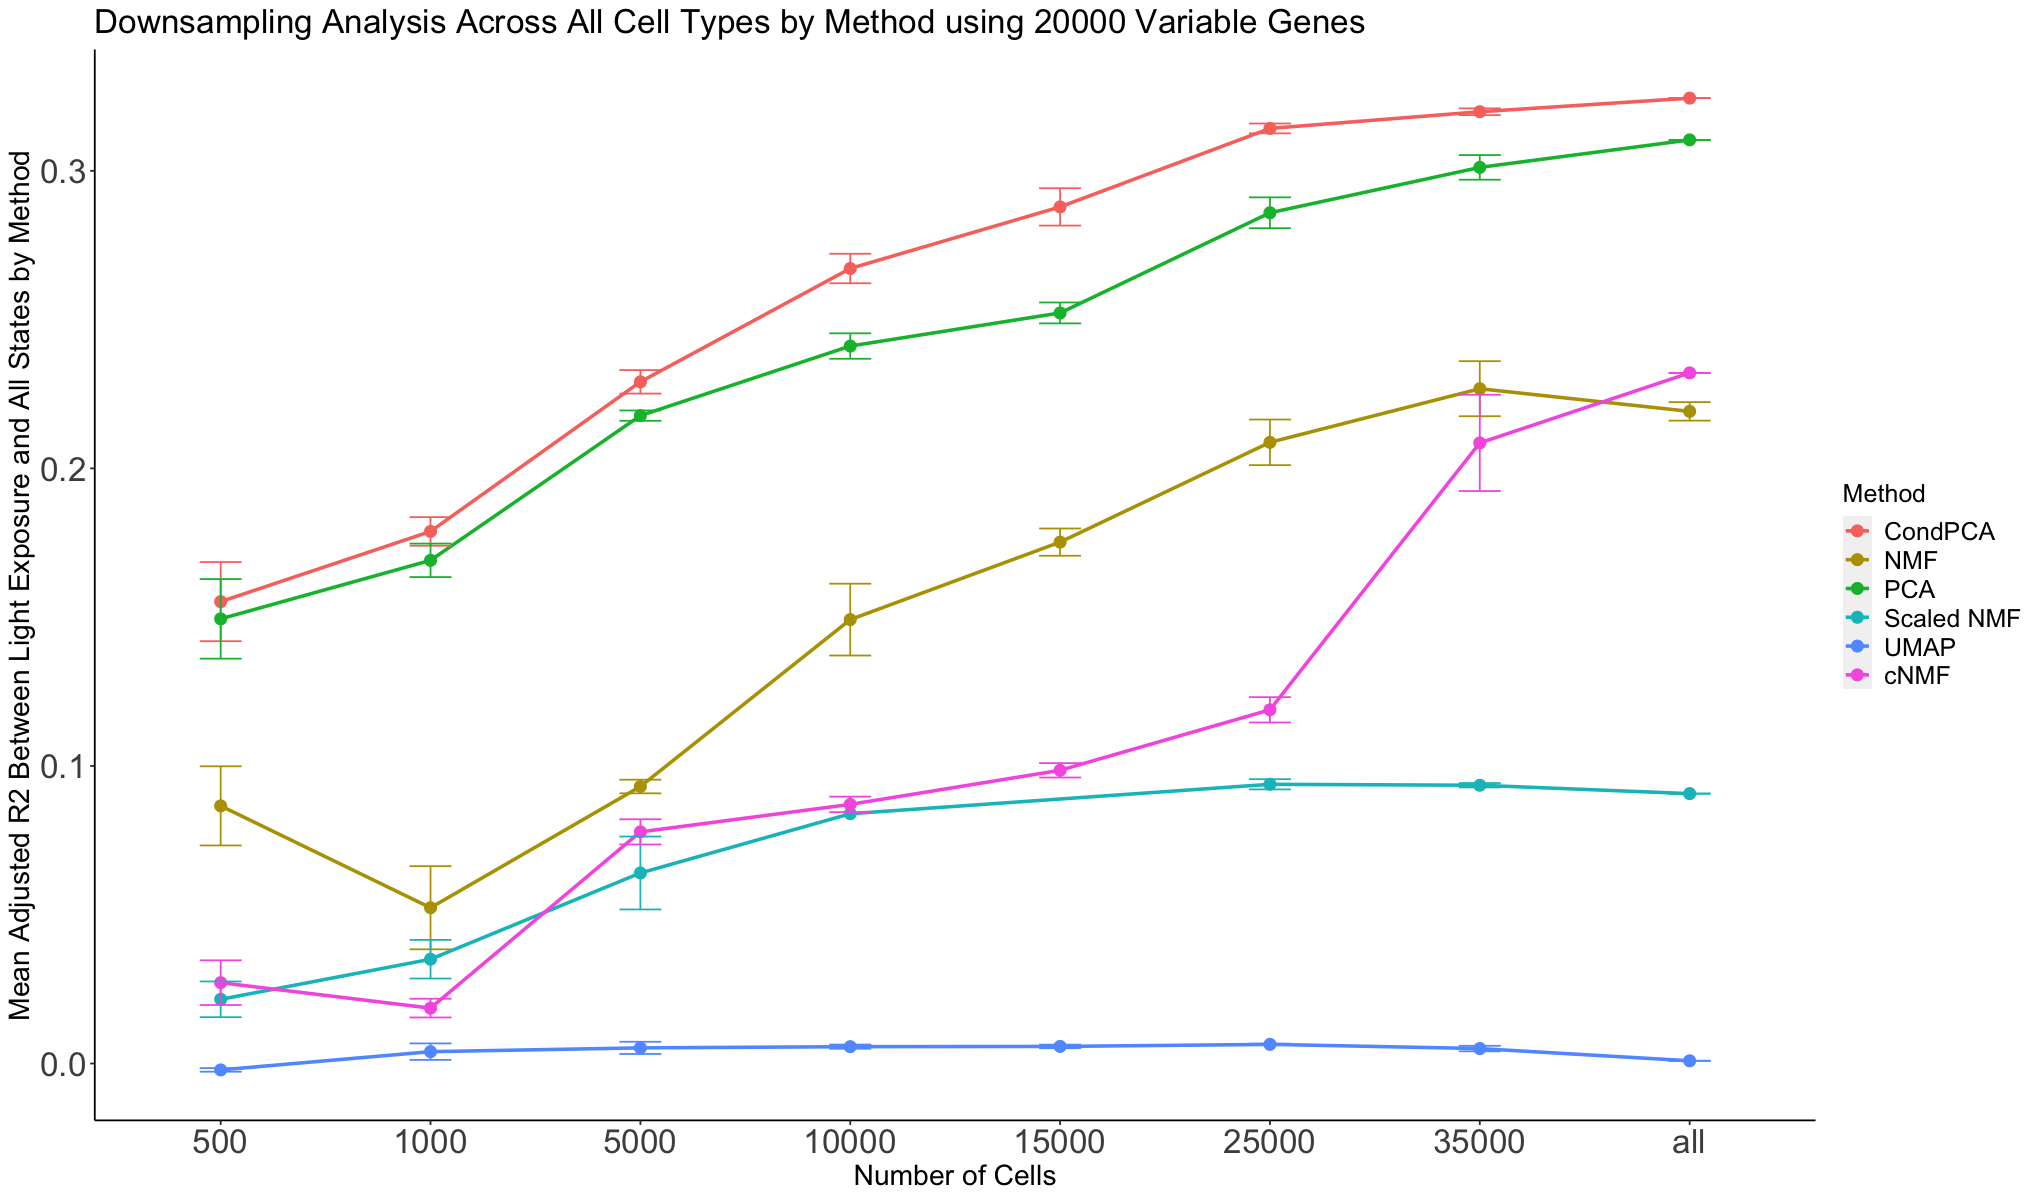

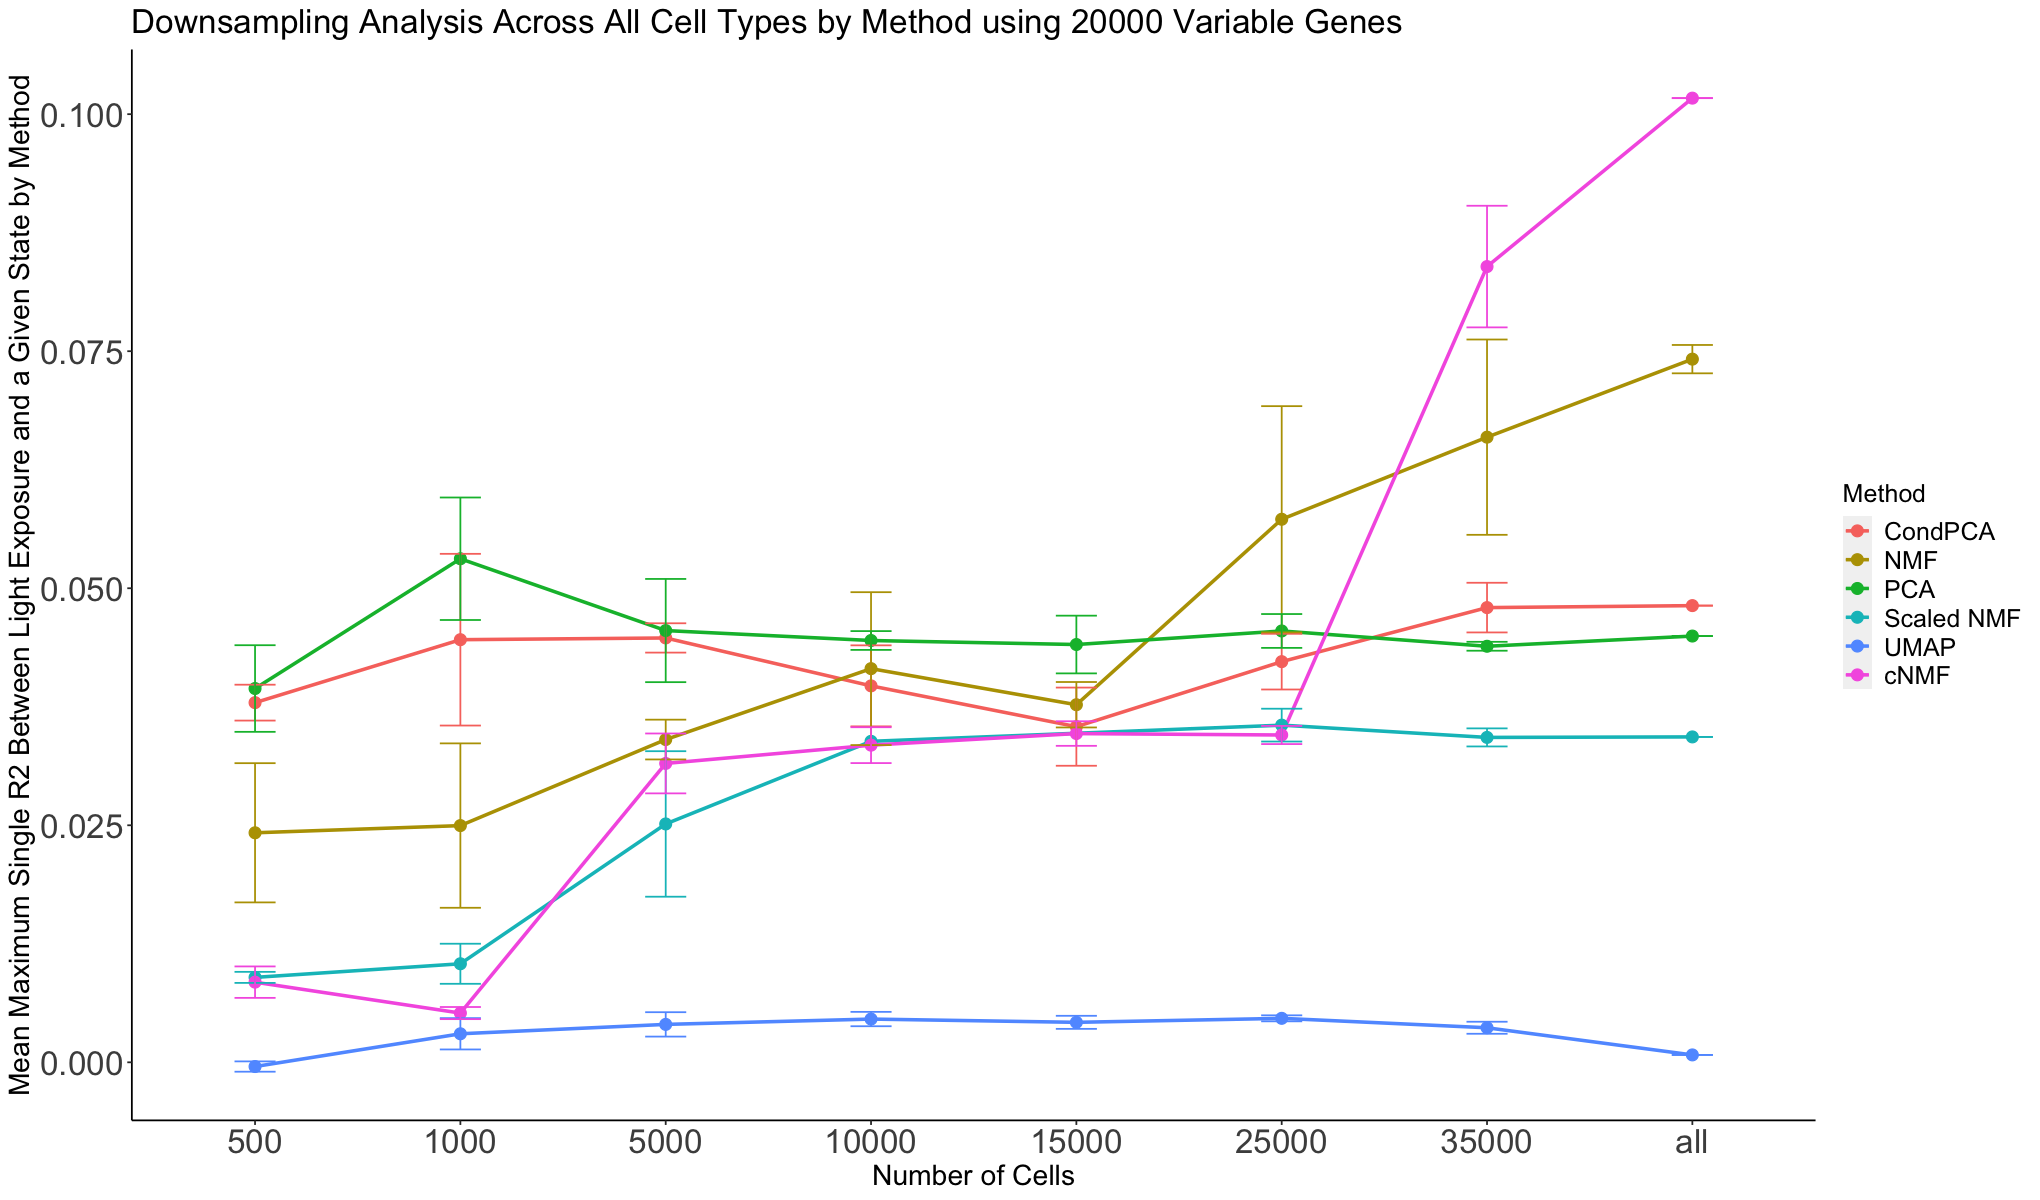

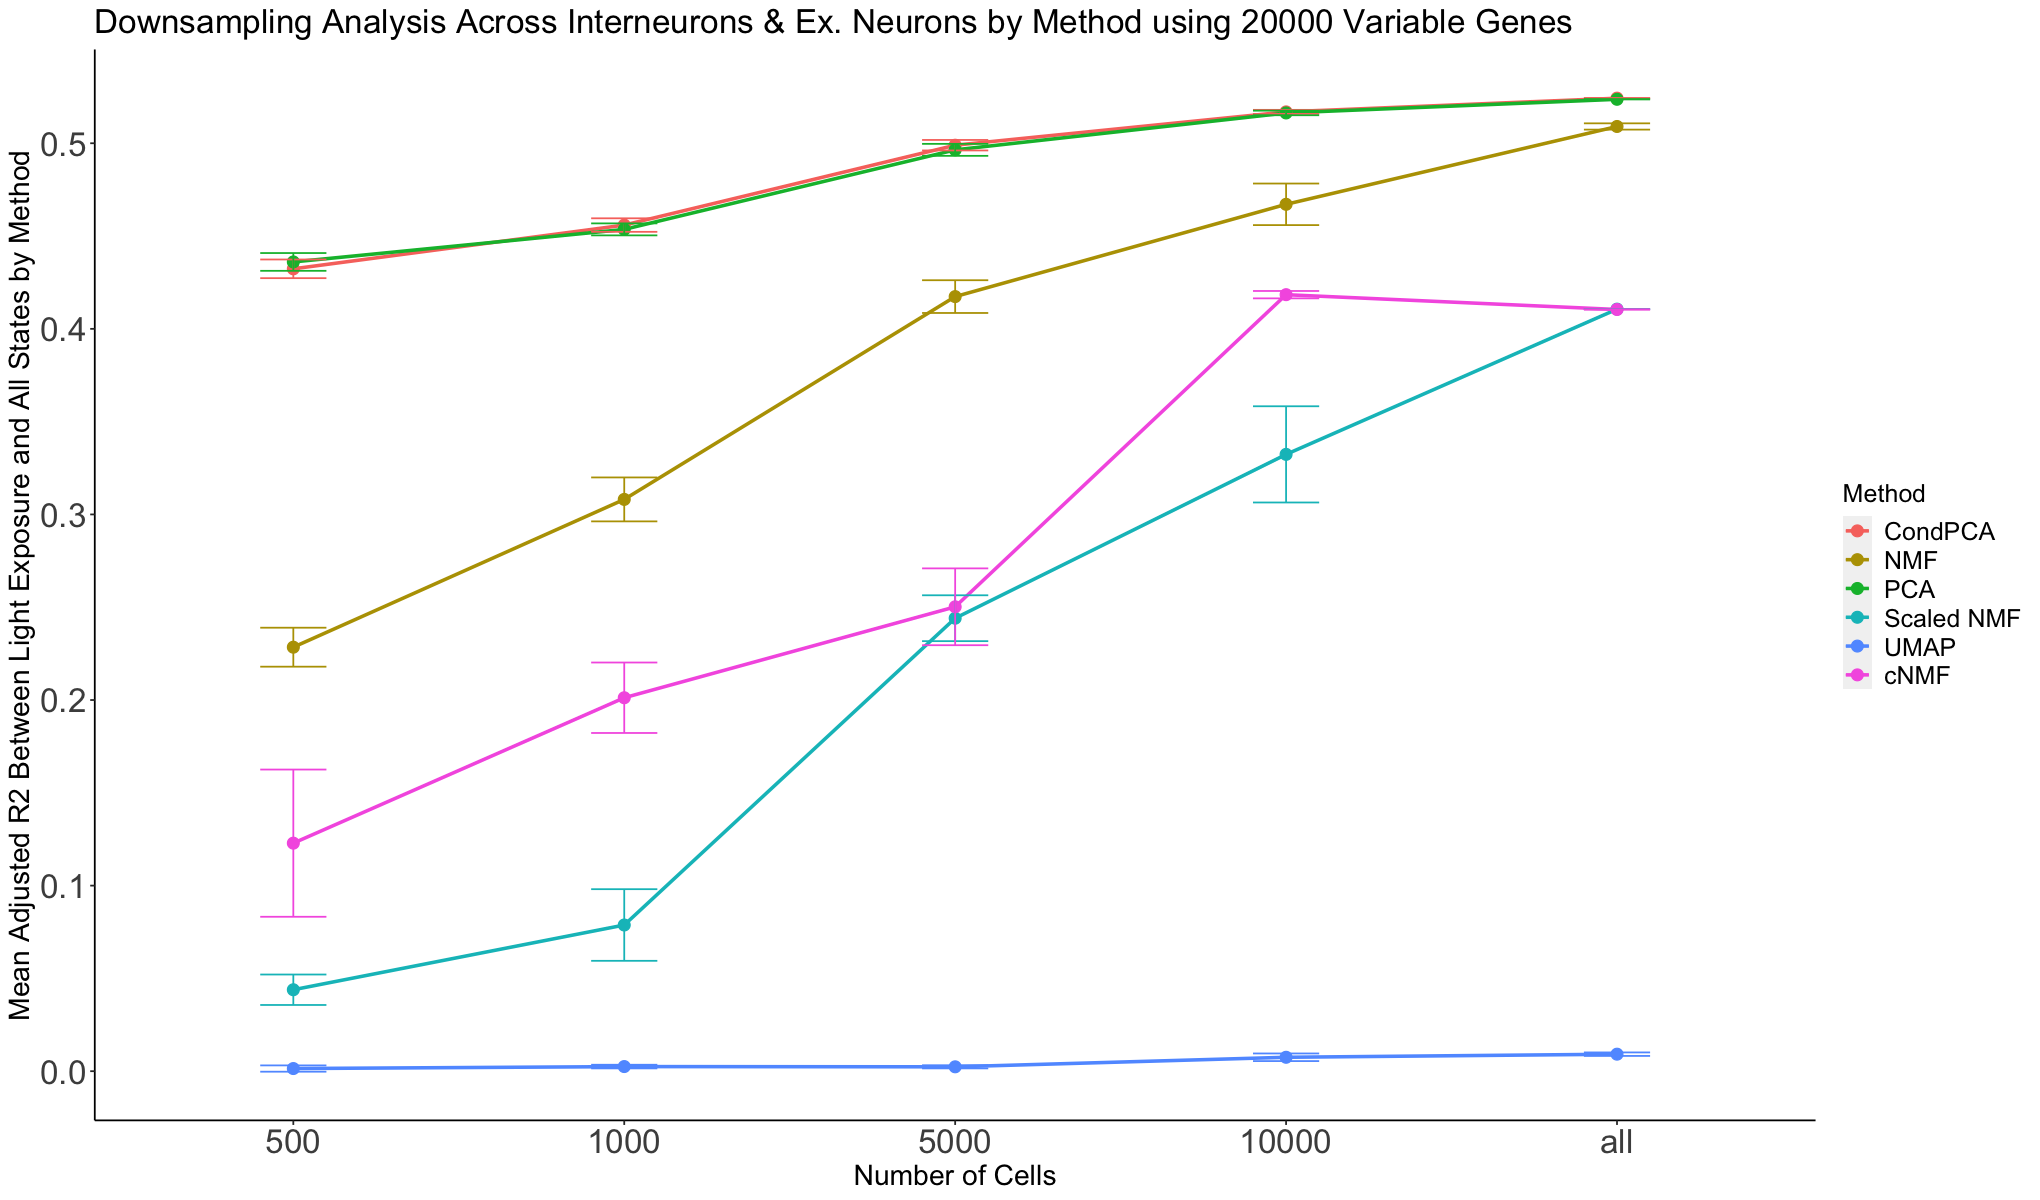

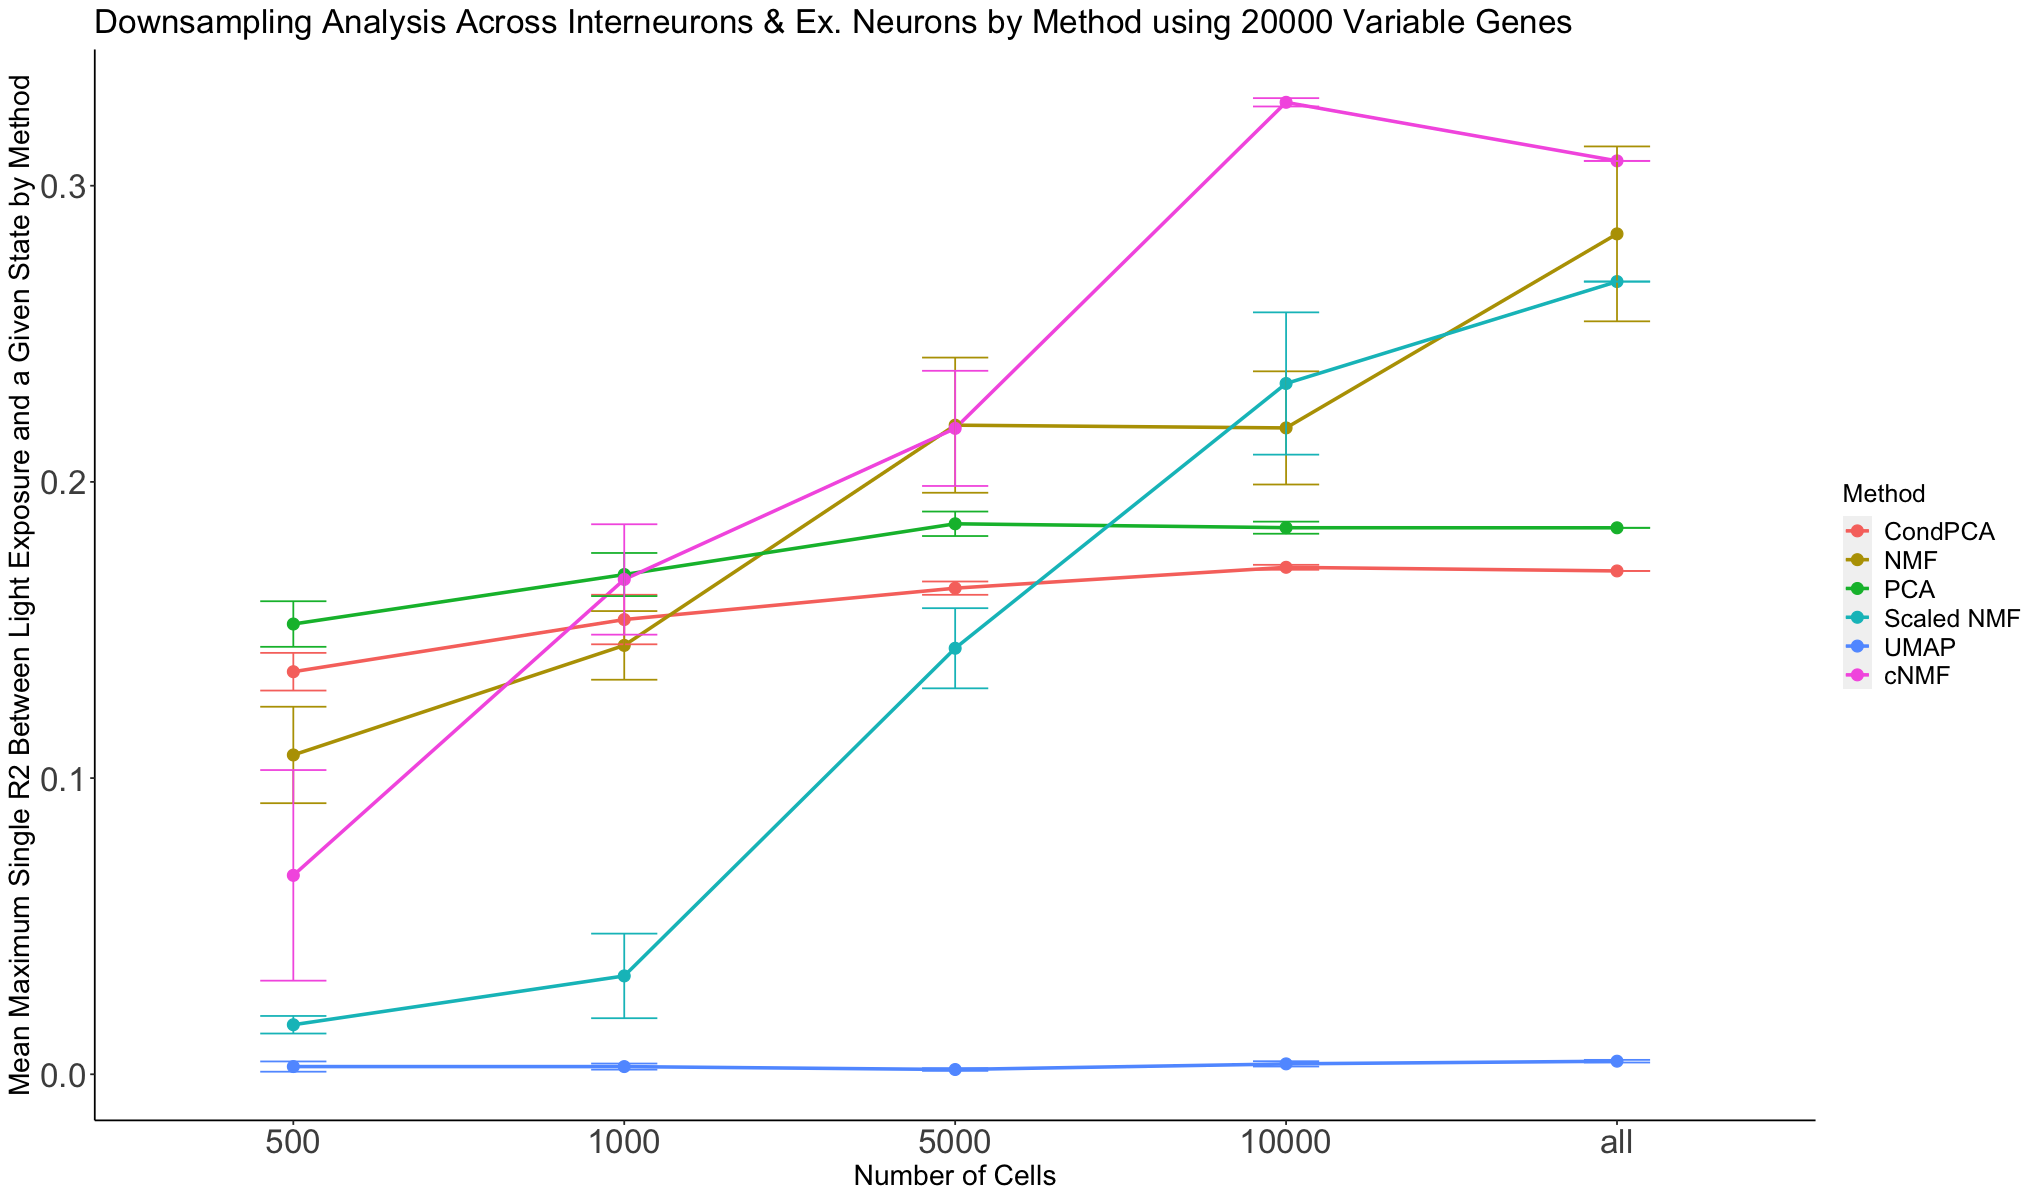

In [6]:
for (subset in unique(merged$data_param)){

    
    for (vargene in unique(out$vargenes) ) {
        for (stat in stats){

            # subset dataframe to parameter of interest
            out = merged[merged$data_param == subset & merged$vargenes == vargene,]

            if (stat == "adj.rsq") {
                ylabel <- "Mean Adjusted R2 Between Light Exposure and All States by Method"
            } else if (stat == "max.rsq") {
                ylabel <- "Mean Maximum Single R2 Between Light Exposure and a Given State by Method"
            } else {
                stop("Unexpected value for 'stat'")
            }

            p = ggplot(out, aes(x=num_cells, y=UQ(as.name( paste0("mean_",stat) )), group=Method, colour=Method)) + geom_line(linewidth=1) + geom_point(size = 3)+ ggtitle(glue('Downsampling Analysis Across {subset} by Method using {vargene} Variable Genes') )+ theme(axis.text.x=element_text(size=20), axis.text.y=element_text(size=20),text = element_text(size = 15), axis.text = element_text(size = 12),axis.title = element_text(size = 17),plot.title = element_text( size = 20),legend.text=element_text(size=15)) + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
            panel.background = element_blank(), axis.line = element_line(colour = "black"))+ labs(y =ylabel , x = "Number of Cells")+ geom_errorbar(aes(ymin = UQ(as.name(paste0("mean_", stat))) - UQ(as.name(paste0("se_", stat))), ymax = UQ(as.name(paste0("mean_", stat))) + UQ(as.name(paste0("se_", stat)))), width = 0.2)
            print(p)
        }


    }
        
}